# starting package

basic start

In [1]:
import torch
import matplotlib.pyplot as plt

from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.layers import linear_block
from jcopdl.callback import Callback, set_config
from tqdm.auto import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
device

device(type='cuda', index=0)

# Dataset & DataLoader

Dataset aksara

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from torch.utils.data import TensorDataset

df=pd.read_csv("water_potability.csv")

X=df.drop(['Potability'],axis=1)
y=df.filter(['Potability']).values

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25, stratify = y ,random_state=42)

numeric=Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ("scaler",MinMaxScaler())
])

# categorical=Pipeline([
#     ('imputer',SimpleImputer(strategy="most_frequent")),
#     ("onehot",OneHotEncoder())
# ])

preprocessor=ColumnTransformer([
    ('numeric', numeric, ['ph','Hardness','Sulfate','Conductivity','Chloramines','Solids','Organic_carbon','Trihalomethanes','Turbidity']),
#     ('categoric', categorical, ['column feature categorical'])
])

X_train=preprocessor.fit_transform(X_train)
X_test=preprocessor.transform(X_test)

X_train=torch.FloatTensor(X_train).to(device)
X_test=torch.FloatTensor(X_test).to(device)
y_train=torch.LongTensor(y_train).to(device)
y_test=torch.LongTensor(y_test).to(device)

bs=64

train_set=TensorDataset(X_train,y_train)
trainloader=DataLoader(train_set, batch_size=bs, shuffle=True)

test_set=TensorDataset(X_test,y_test)
testloader=DataLoader(test_set, batch_size=bs)

In [3]:
for feature, target in testloader:
    output = model(feature)
    print (output.argmax(1))

print(X)


NameError: name 'model' is not defined

# Arsitektur & Config

default nn classifier

In [4]:
class CustomClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, n3, output_size, dropout):
        super().__init__()
        self.fc=nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(input_size, n1),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(n1, n2),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(n2, n3),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(n3, output_size),
            nn.LogSoftmax(1),
        )
        
    def forward(self, x):
        x = self.fc(x)
        return x

default cnn classifier

In [5]:
config= set_config({
    "batch_size":bs,
    "input_size":9,
    "n1":16,
    "n2":8,
    "n3":4,
    "output_size": 2,
    "dropout":0.2
})

# Training Preparation ( MCOC )

In [6]:
model=CustomClassifier( config.input_size, config.n1, config.n2, config.n3, config.output_size, config.dropout).to(device)
citerion=nn.NLLLoss()
optimizer=optim.AdamW(model.parameters(), lr=0.001)
callback=Callback(model, config, outdir="model", save_every=20, early_stop_patience=10, plot_every= 20)

# Training

In [7]:
def loop_fn(mode, dataset, dataloader, model, citerion, optimizer, device):
    if mode =='train':
        model.train()
    elif mode =='test':
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = citerion(output, target.squeeze_())
        
        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc    

In [ ]:
len(train_set)



Epoch     1
Train_cost  = 0.6840 | Test_cost  = 0.6754 | Train_score = 0.5648 | Test_score = 0.6105 |




Epoch     2
Train_cost  = 0.6748 | Test_cost  = 0.6695 | Train_score = 0.6051 | Test_score = 0.6105 |
==> EarlyStop patience =  1 | Best test_score: 0.6105




Epoch     3
Train_cost  = 0.6731 | Test_cost  = 0.6687 | Train_score = 0.6076 | Test_score = 0.6105 |
==> EarlyStop patience =  2 | Best test_score: 0.6105




Epoch     4
Train_cost  = 0.6681 | Test_cost  = 0.6686 | Train_score = 0.6076 | Test_score = 0.6105 |
==> EarlyStop patience =  3 | Best test_score: 0.6105




Epoch     5
Train_cost  = 0.6690 | Test_cost  = 0.6685 | Train_score = 0.6133 | Test_score = 0.6105 |
==> EarlyStop patience =  4 | Best test_score: 0.6105




Epoch     6
Train_cost  = 0.6723 | Test_cost  = 0.6687 | Train_score = 0.6084 | Test_score = 0.6105 |
==> EarlyStop patience =  5 | Best test_score: 0.6105




Epoch     7
Train_cost  = 0.6722 | Test_cost  = 0.6685 | Train_score = 0.6100 | Test_score = 0.6105 |
==> EarlyStop patience =  6 | Best test_score: 0.6105




Epoch     8
Train_cost  = 0.6728 | Test_cost  = 0.6688 | Train_score = 0.6100 | Test_score = 0.6105 |
==> EarlyStop patience =  7 | Best test_score: 0.6105




Epoch     9
Train_cost  = 0.6697 | Test_cost  = 0.6684 | Train_score = 0.6100 | Test_score = 0.6105 |
==> EarlyStop patience =  8 | Best test_score: 0.6105




Epoch    10
Train_cost  = 0.6695 | Test_cost  = 0.6686 | Train_score = 0.6100 | Test_score = 0.6105 |
==> EarlyStop patience =  9 | Best test_score: 0.6105




Epoch    11
Train_cost  = 0.6709 | Test_cost  = 0.6685 | Train_score = 0.6100 | Test_score = 0.6105 |
==> EarlyStop patience = 10 | Best test_score: 0.6105
==> Execute Early Stopping at epoch: 11 | Best test_score: 0.6105
==> Best model is saved at model


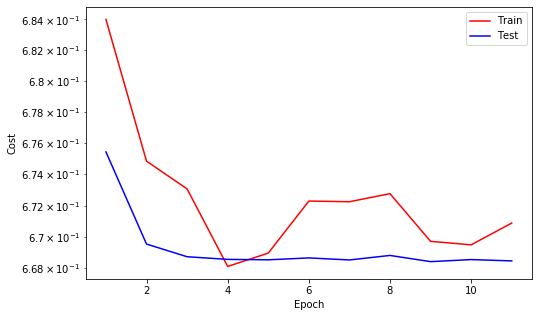

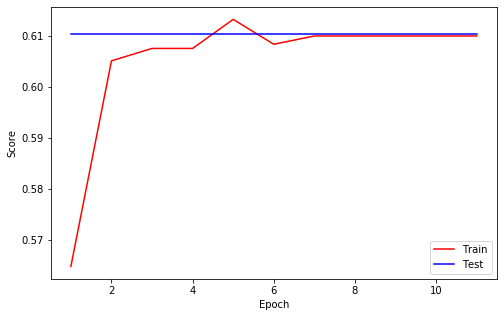

In [8]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, citerion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, citerion, optimizer, device)
        
    callback.log(train_cost, test_cost, train_score, test_score)
    callback.save_checkpoint()
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Load Model

In [ ]:
weights=torch.load("your directory/weights_best.pth", map_location="cpu")
config=torch.load("your directory/configs.pth", map_location="cpu")

model=CustomClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout)
model.load_state_dict(weights)
model=model.to(device)

# Predict

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

label2cat=train_set.classes

with torch.no_grad():
    model.eval()
    output = model(feature)
    predictions = output.argmax(1)
[label2cat[prediction] for prediction in predictions]

# Visualisasi Predictions ( image dataset ) 

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(25, 25))
for img, label, prediction, ax in zip(feature, target, predictions, axes.flatten()):
    ax.imshow(img.view(28, 28).cpu(), cmap='')
    font= {'color' : 'r'} if label != pred else {'color' : 'g'}
    label, prediction = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f" Label: {label} | Pred: {prediction}",fontdict = font);
    ax.axis('off')''